# Unsupervised Analysis - *twitter* - Kehidupan Beragama (Islam) 2009-2019

0. Data Basic Statistics:
 - Data sizes: tweets, users, followers info, location Info, tweets/year
 - Sampling
 - HashTags analysis
 - Filtering
 
1. Label Analysis:
 - Frequency
 - Text Analytics
 - Jaccard Distance in Labeled Data

2. Location Analysis:
 - All years
 - All Years + Category
 - Per year 2009-2019
 
3. Topic Modelling
 - All Year
 - Per year 2009-2019
 
4. Social Network Analysis
 - All Years Followers: Centrality by Degree, Total engagement, mean engagement
 - All Years Mention: Centrality by Degree, Total engagement, mean engagement
 - Per Year Follower: eigen
 - Per Year Mention: eigen

In [1]:
import warnings; warnings.simplefilter('ignore')
import taudata_crawl_tweet as tau, re, pickle, os, networkx as nx
import pandas as pd, numpy as np, seaborn as sns, bz2, time, chardet
from scipy import stats
from shutil import copyfileobj
from tqdm import tqdm_notebook as tqdm
from textblob import TextBlob
import taudata as tau2

# Explanation Filtering Method

# Importing Data

In [7]:
print('Labeled Data: ')
with open('data/Tweet_Labels.csv', 'rb') as f:
    result = chardet.detect(f.readline())  # or readline if the file is large
data_Labelled = pd.read_csv('data/Tweet_Labels.csv', error_bad_lines=False, low_memory = False, encoding=result['encoding'])

print('Loading All Tweets ... ')
try:
    f = open('data/AllTweets.pckl', 'rb')
    all_data = pickle.load(f); f.close()
except:
    pass

print('2nd level whitelisted usernames')
try:
    f = open('data/whitelist_2nd_Level.pckl', 'rb')
    whitelist_2nd = pickle.load(f); f.close()
except:
    pass

print('3rd level whitelisted usernames')
try:
    f = open('data/whitelist_3rd_Level.pckl', 'rb')
    whitelist_3rd = pickle.load(f); f.close()
except:
    pass

print('4th level whitelisted usernames')
try:
    f = open('data/whitelist_4th_Level.pckl', 'rb')
    whitelist = pickle.load(f); f.close()
except:
    pass

print('Filtered Tweets: ')
try:
    f = open('data/FilteredTweets.pckl', 'rb')
    filteredTweets = pickle.load(f); f.close()
except:
    pass

print('Loading All Users ... ')
try:
    f = open('data/AllUsers.pckl', 'rb')
    users = pickle.load(f); f.close()
except:
    pass

print('Loading Filtered Users ... ')
try:
    f = open('data/FilteredUsers.pckl', 'rb')
    FilteredUsers = pickle.load(f); f.close()
except:
    pass

print('Loading Filtered Followers Information: ... ')
try:
    f = open('data/FilteredFollowers.pckl', 'rb')
    FilteredFollowers = pickle.load(f); f.close()
except:
    pass

'Done'

Labeled Data: 
Loading All Tweets ... 
2nd level whitelisted usernames
3rd level whitelisted usernames
4th level whitelisted usernames
Filtered Tweets: 
Loading All Users ... 
Loading Filtered Users ... 
Loading Filtered Followers Information: ... 


'Done'

In [8]:
print('Total Number of Tweets = ', all_data.shape[0])
print('Total Number of Distinct Users = ', users.shape[0])
print('Total Number of Filtered Followers Information = ', FilteredFollowers.shape[0]*2)

Total Number of Tweets =  1939777
Total Number of Distinct Users =  715888
Total Number of Filtered Followers Information =  6906946


# Data Basic Statistics

In [15]:
filteredTweets[['screen_name', 'nretweets', 'nlikes', 'nreplies']].describe(include='all')

,screen_name,nretweets,nlikes,nreplies
count,1262387,173770.000000,1.737700e+05,173770.000000
unique,347288,NaN,NaN,NaN
top,RIBA,NaN,NaN,NaN
freq,8461,NaN,NaN,NaN
mean,NaN,32.063843,5.256295e+01,7.439224
std,NaN,1668.006124,4.962711e+03,516.719645
min,NaN,0.000000,0.000000e+00,0.000000
25%,NaN,0.000000,0.000000e+00,0.000000
50%,NaN,0.000000,0.000000e+00,0.000000
75%,NaN,2.000000,0.000000e+00,0.000000


In [17]:
FilteredUsers[['followers_count', 'statuses_count']].describe(include='all')

,followers_count,statuses_count
count,1.665200e+04,1.665200e+04
mean,3.270520e+04,3.102099e+04
std,3.112603e+05,8.263957e+04
min,0.000000e+00,1.000000e+00
25%,3.510000e+02,3.844750e+03
50%,9.410000e+02,1.213400e+04
75%,3.775500e+03,3.226425e+04
max,1.579483e+07,5.368762e+06


# Data Frequency based-on years

2012    333831
2011    265287
2013    251301
2014    219562
2015    170154
2010    134559
2018    131909
2017    129973
2016    129083
2009     36618
2019     18523
Name: year, dtype: int64

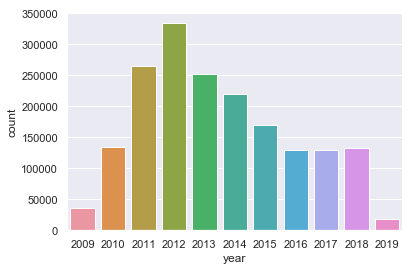

In [61]:
years = list(map(str,range(2009,2020)))
dty = {'year':[]}
for i, d in tqdm(all_data.iterrows()):
    for y in years:
        if y in str(d.created_at):
            dty['year'].append(y); break
dty = pd.DataFrame.from_dict(dty)
p = sns.countplot(x="year", data=dty)
dty['year'].value_counts()

# Labeled Data Frequency

0    49920
3     5879
2     1719
1      849
4      255
5       65
Name: label, dtype: int64

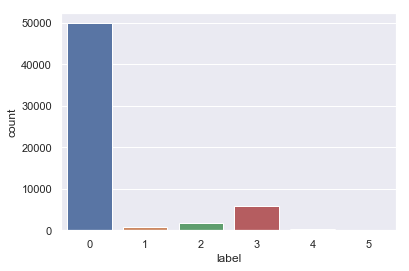

In [49]:
names = ['Iim', 'Yani', 'Endi', 'Fahmi', 'Aziz', 'Dita']
cols = ['tweetID', 'screen_name', 'tweet']
dt = {c:[] for c in cols}
dt['label'] = []
for i, d in data_Labelled.iterrows():
    scores = [int(d[name]) for name in names if str(d[name]).isdigit()]
    scores.sort(reverse = True) # Default to largest Category when Mode = NaN
    try:
        mode, freq = stats.mode(scores); mode = mode[0]
    except:
        mode = 0
    if mode>5:
        mode = 0
    dt['label'].append(mode)
    for c in cols:
        dt[c].append(d[c])
dt = pd.DataFrame.from_dict(dt)
p = sns.countplot(x="label", data=dt)
dt['label'].value_counts()

In [59]:
d.created_at.year

2013